In [14]:
from funcs import *
from tqdm import tqdm
import matplotlib
%matplotlib widget

In [15]:
@jit(nopython=True)
def F(u):
    return 0.0

@jit(nopython=True)
def leftGU(x,y):
    return 0.0

@jit(nopython=True)
def rightGU(x,y):
    return 0.0

NU_ = Distrib(make_func("triangle_m_f", [-0.5,0.0,0.5]), supp_of_func=(-0.5,0.0,0.5))

def NU(x,y,xgrid,ygrid):
    return NU_(x)*NU_(y)  


@jit(nopython =True)
def D(x,y,u):
    return 1.0


@jit(nopython=True)
def Kx(xl,xr,y,ul,ur):
    return 0.5*(D(xl,y,ul)+D(xr,y,ur))

@jit(nopython=True)
def Ky(x,yl,yr,ul,ur):
    return 0.5*(D(x,yl,ul)+D(x,yr,ur))

@jit(nopython=True)
def phi(u_next_k, u_k):
    return 0.5*(F(u_next_k)+F(u_k))

In [16]:
@jit(nopython=True)
def balance_solve(Nx,Ny,Nt,hx,hy,tau,t,x,y,u_):
    u = np.copy(u_)    
    B = np.zeros(shape=(Nx,))
    A = np.zeros(shape=(Nx, Nx))

    By = np.zeros(shape=(Ny,))
    Ay = np.zeros(shape=(Ny, Ny))
    end_ = False
    for k in range(Nt-1):
        u_s = np.copy(u[k])        
        for j in range(1,Ny-1):
            for s in range(20):
                A[0][0] = -1.0/hx
                A[0][1] = 1.0/hx
                A[Nx-1][Nx-1] = 1.0/hx 
                A[Nx-1][Nx-2] = -1.0/hx
                for i in range(1,Nx-1):
                    A[i][i-1] = -1.0/(hx**2)*Kx(x[i-1],x[i],y[j],u_s[i-1][j],u_s[i][j])
                    A[i][i]   = 2.0/tau+1.0/(hx**2)*Kx(x[i-1],x[i],y[j],u_s[i-1][j],u_s[i][j])+1.0/(hx**2)*Kx(x[i],x[i+1],y[j],u_s[i][j],u_s[i+1][j])
                    A[i][i+1] = -1.0/(hx**2)*Kx(x[i],x[i+1],y[j],u_s[i][j],u_s[i+1][j])
                    
                B[0] = leftGU(x[0],y[j])
                B[Nx-1] = rightGU(x[Nx-1],y[j])
                for i in range(1,Nx-1):
                    B[i] = phi(u_s[i][j],u[k][i][j])+2.0/tau*u[k][i][j] + (1.0/(hy**2)*Ky(y[j-1],y[j],x[i],u_s[i][j-1],u_s[i][j]))*u[k][i][j-1]-\
                    (2.0/tau+1.0/(hy**2)*Ky(y[j-1],y[j],x[i],u_s[i][j-1],u_s[i][j])+1.0/(hy**2)*Ky(y[j],y[j+1],x[i],u_s[i][j],u_s[i][j+1]))*u[k][i][j]+\
                    1.0/(hy**2)*Ky(y[j],y[j+1],x[i],u_s[i][j],u_s[i][j+1])*u[k][i][j+1]
                
                u_s[:,j] = progonka(A,B)
        
        u_tau_pola = np.copy(u_s)
        for i in range(1,Nx-1):
            for s in range(20):
                Ay[0][0] = -1.0/hy
                Ay[0][1] = 1.0/hy
                Ay[Ny-1][Ny-1] = 1.0/hy 
                Ay[Ny-1][Ny-2] = -1.0/hy

                for j in range(1,Ny-1):
                    Ay[j][j-1] = -1.0/(hy**2)*Ky(y[j-1],y[j],x[i],u_s[i][j-1],u_s[i][j])
                    Ay[j][j]   = 2.0/tau+1.0/(hy**2)*Ky(y[j-1],y[j],x[i],u_s[i][j-1],u_s[i][j])+1.0/(hy**2)*Ky(y[j],y[j+1],x[i],u_s[i][j],u_s[i][j+1])
                    Ay[j][j+1] = -1.0/(hy**2)*Ky(y[j],y[j+1],x[i],u_s[i][j],u_s[i][j+1])

                By[0] = leftGU(x[i],y[0])
                By[Ny-1] = rightGU(x[i],y[Ny-1])
                for j in range(1,Ny-1):
                    By[j] = phi(u_s[i][j],u_tau_pola[i][j])+2.0/tau*u_tau_pola[i][j]+ 1.0/(hx**2)*Kx(x[i-1],x[i],y[j],u_tau_pola[i-1][j],u_tau_pola[i][j])*u_tau_pola[i-1][j]-\
                    (2.0/tau+1.0/(hx**2)*Kx(x[i-1],x[i],y[j],u_tau_pola[i-1][j],u_tau_pola[i][j])+1.0/(hx**2)*Kx(x[i],x[i+1],y[j],u_tau_pola[i][j],u_tau_pola[i+1][j]))*u_tau_pola[i][j]+\
                    1.0/(hx**2)*Kx(x[i],x[i+1],y[j],u_tau_pola[i][j],u_tau_pola[i+1][j])*u_tau_pola[i+1][j]
                u_s[i,:] = progonka(Ay,By)

        if np.sum(np.isnan(u_s)) > 0 or np.sum(np.isinf(u_s)) > 0 or np.sum(u_s < 0.0) > 0:
            end_ = True
        if end_:
            return u[:k+1]
        u[k+1] = np.copy(u_s)
    return u

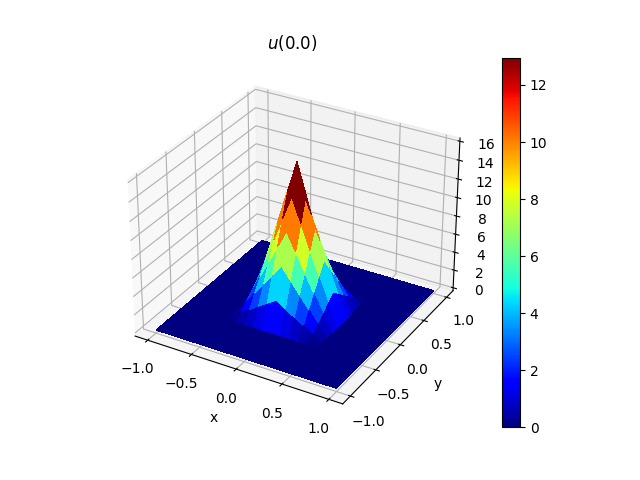

In [17]:
hx = 0.1
ax= -1.0
bx = 1.0
Nx=  int((bx-ax)/hx)+1
xgrid = np.linspace(ax,bx,num=Nx)

hy = 0.1
ay= -1.0
by = 1.0
Ny=  int((by-ay)/hy)+1
ygrid = np.linspace(ay,by,num=Ny)

tau = 0.01
T = 0.3
t0 = 0.0
Nt = int((t0+T-t0)/tau) + 1
tgrid = np.linspace(start=t0, stop=t0+T,num=Nt)
t = np.copy(tgrid)
x = np.copy(xgrid)
y= np.copy(ygrid)
u = np.zeros(shape=(len(tgrid),len(xgrid),len(ygrid)))

for i in range(len(x)):
    for j in range(len(y)):
        u[0][i][j] = NU(x[i],y[j],x,y)

u = balance_solve(Nx,Ny,Nt,hx,hy,tau,t,x,y,u)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, u[-1], cmap=matplotlib.cm.jet,
                    linewidth=0, antialiased=False)
fig.colorbar(surf)
ax.set_title(r'$u({})$'.format((len(u)-1)*tau))
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()